In [80]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, confusion_matrix

In [81]:
# Load the dataset
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

# Prepare features and label data
label = 'PlayoffNextSeason'
features = [col for col in dataset.columns if col != label]

X = dataset[features]
y = dataset[label]

# Handle missing values
X = X.fillna(X.mean())

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [82]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Define the objective function for Optuna with RFE
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float('C', 0.01, 10, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
    # Suggest l1_ratio only for elasticnet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    n_features_to_select = trial.suggest_int('n_features_to_select', 1, len(features))

    # Skip invalid combinations
    if solver in ['lbfgs', 'newton-cg'] and penalty == 'l1':
        return float('-inf')
    if solver == 'liblinear' and penalty == 'elasticnet':
        return float('-inf')
    if penalty == 'elasticnet' and solver != 'saga':
        return float('-inf')

    # Create the base logistic regression model with a fixed random state
    base_model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        random_state=42
    )

    # Perform RFE for feature selection
    rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)

    # Perform stratified k-fold cross-validation on selected features (consistent random_state)
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(base_model, X_selected, y, cv=skf, scoring='accuracy', error_score='raise')

    # Return the mean accuracy as the objective value
    return np.mean(cv_scores)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize', study_name="Logistic Regression with RFE Optimization")
study.optimize(objective, n_trials=50)

[I 2024-12-20 11:10:57,307] A new study created in memory with name: Logistic Regression with RFE Optimization
[I 2024-12-20 11:10:57,310] Trial 0 finished with value: -inf and parameters: {'C': 0.1861248325040459, 'solver': 'lbfgs', 'penalty': 'elasticnet', 'l1_ratio': 0.20927369759439407, 'max_iter': 384, 'n_features_to_select': 17}. Best is trial 0 with value: -inf.
[I 2024-12-20 11:10:57,312] Trial 1 finished with value: -inf and parameters: {'C': 1.1801399301568967, 'solver': 'newton-cg', 'penalty': 'elasticnet', 'l1_ratio': 0.9360103160700196, 'max_iter': 932, 'n_features_to_select': 24}. Best is trial 0 with value: -inf.
[I 2024-12-20 11:10:57,314] Trial 2 finished with value: -inf and parameters: {'C': 0.03067282821780861, 'solver': 'newton-cg', 'penalty': 'elasticnet', 'l1_ratio': 0.07746446595072154, 'max_iter': 938, 'n_features_to_select': 9}. Best is trial 0 with value: -inf.
[I 2024-12-20 11:10:57,315] Trial 3 finished with value: -inf and parameters: {'C': 0.1066147840991

In [83]:
# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy from Optuna: {study.best_value:.4f}")

# Retrieve best parameters
best_params = study.best_params
best_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    l1_ratio=best_params.get('l1_ratio'),
    random_state=42
)


Best parameters:
{'C': 2.6967233066884235, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 539, 'n_features_to_select': 13}
Best cross-validated accuracy from Optuna: 0.8157


In [84]:
# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy: {study.best_value:.4f}")

# Train the best model with the best parameters and selected features
best_params = study.best_params
best_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    penalty=best_params['penalty'],
    max_iter=best_params['max_iter'],
    l1_ratio=best_params.get('l1_ratio')
)


Best parameters:
{'C': 2.6967233066884235, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 539, 'n_features_to_select': 13}
Best cross-validated accuracy: 0.8157


In [85]:
# Perform RFE with the best number of features
rfe = RFE(estimator=best_model, n_features_to_select=best_params['n_features_to_select'])
X_selected = rfe.fit_transform(X, y)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print(f"Selected Features: {selected_features}")

# Train the final model on selected features
best_model.fit(X_selected, y)

Selected Features: ['Rank', 'PlayoffProgScore', 'W', 'FTA', 'REB', 'AST', 'TOV', 'NETRTG', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach']


LogisticRegression(C=2.6967233066884235, max_iter=539, solver='liblinear')


Feature Importance After RFE:
                       Feature  Coefficient  Absolute Importance
1             PlayoffProgScore     1.978256             1.978256
0                         Rank     1.777064             1.777064
2                            W     1.709448             1.709448
11      AvgPIE_NextYearPlayers     1.358578             1.358578
8                       AST/TO     1.128945             1.128945
5                          AST    -1.049530             1.049530
3                          FTA    -1.039542             1.039542
9                         REB%     0.991357             0.991357
12   Performance_NextYearCoach    -0.971558             0.971558
4                          REB     0.853170             0.853170
7                       NETRTG    -0.573118             0.573118
10  CumulativePlayoffProgScore     0.563389             0.563389
6                          TOV     0.558706             0.558706


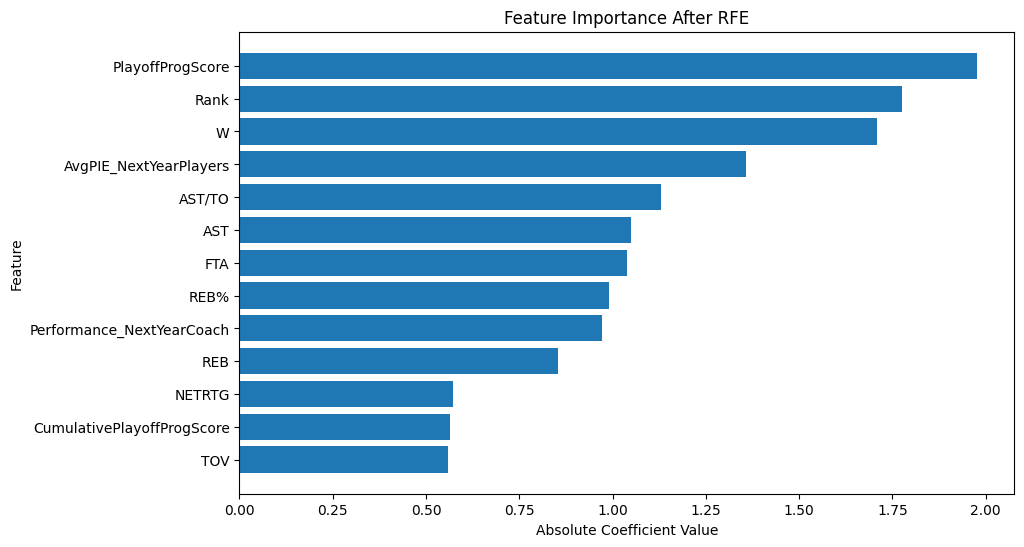

In [86]:
# Get feature importance
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)
}).sort_values(by='Absolute Importance', ascending=False)

print("\nFeature Importance After RFE:")
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance After RFE')
plt.gca().invert_yaxis()
plt.show()

In [87]:
# Evaluate the final model on multiple metrics with fixed random state for CV
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': make_scorer(specificity_score)
}

final_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_selected, y, cv=final_skf, scoring=scoring)

# Print results
print("\nEvaluation metrics for the final model:")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# For direct comparison, print the final accuracy again using the same CV as in the objective
final_cv_scores = cross_val_score(best_model, X_selected, y, cv=final_skf, scoring='accuracy')
print(f"\nFinal cross-validated accuracy (with best params): {np.mean(final_cv_scores):.4f}")


Evaluation metrics for the final model:
Accuracy - Mean: 0.8157, Std: 0.0808
Precision - Mean: 0.8209, Std: 0.1104
Recall - Mean: 0.8304, Std: 0.1075
F1 - Mean: 0.8182, Std: 0.0809
Roc_auc - Mean: 0.8709, Std: 0.0916
Specificity - Mean: 0.8018, Std: 0.1465

Final cross-validated accuracy (with best params): 0.8157
